<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/Monai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **== Import ==**

In [ ]:
!pip install monai

In [2]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable
import time

import torch

import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection

from monai.data import (Dataset, ArrayDataset, CacheDataset, PersistentDataset, SmartCacheDataset,
                        DataLoader, create_test_image_3d)

from monai.transforms import (Transform, MapTransform, Randomizable, EnsureChannelFirst, EnsureChannelFirstd,
Compose, LoadImage, LoadImaged, Lambda, Lambdad, RandSpatialCrop, RandSpatialCropd, RandGaussianNoise,
RandGaussianNoised, Orientation, Rotate, MapTransform)

from monai.apps import DecathlonDataset, TciaDataset
from monai.apps.tcia import TCIA_LABEL_DICT

# **== Core basic ==**
* Transform
* Dataset
* Dataloader
* Dataset caching
* Layers

Transform

In [3]:
fn_keys = ("img", "seg")

root_dir = tempfile.mkdtemp()
filenames = []

for i in range(5):
    # 創造3D影像 -> (128, 128, 128), 每個影像中有16個物體, 每個物體最大半徑15
    img, seg = create_test_image_3d(128, 128, 128, num_objs = 16, rad_max = 25)

    img_filename = f"{root_dir}/img{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img":img_filename, "seg":seg_filename})

    n = nib.Nifti1Image(img, np.eye(4))
    nib.save(n, img_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

In [7]:
# Transform test
# 創立transform
transorm_temp = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst()
])

# pick first img
img = transorm_temp(filenames[0]["img"])

print(f"Image type: {type(img)}\nImage shape: {img.shape}")

Image type: <class 'monai.data.meta_tensor.MetaTensor'>
Image shape: torch.Size([1, 128, 128, 128])


In [14]:
# Dictionary transform
transform_dict = LoadImaged(keys = fn_keys, image_only = False)

# 直接傳入 {"img":img, "seg",seg}
data = transform_dict(filenames[0])

print(f"回傳類型: {type(data)}\n{list(data.keys())}")

回傳類型: <class 'dict'>
['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


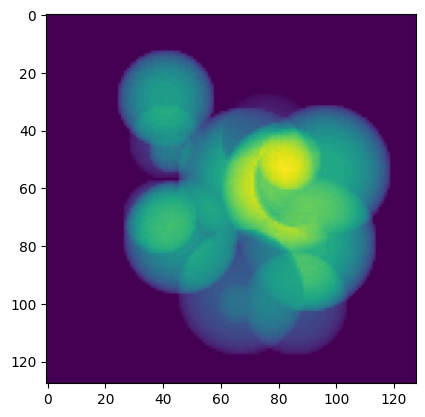

In [20]:
# Custom transform by function -> 三維 -> 二維
def sum_width(img):
    return img.sum(1)   # sum(1) 計算第一維度總和

transform_custom = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    Lambda(sum_width)
])

img = transform_custom(filenames[0]["img"])
plt.imshow(img[0])

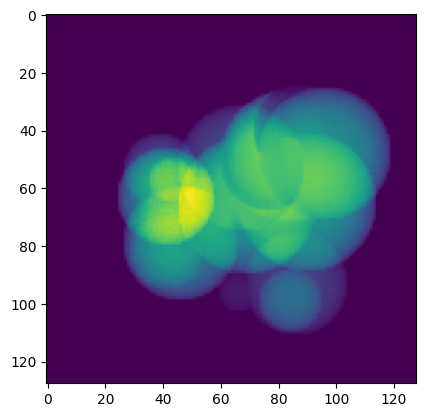

In [26]:
# Custom transform by subclass
class SunDimension(Transform):
    def __init__(self, dim = 1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

transform_custom2 = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    SunDimension(2)
])

img = transform_custom2(filenames[0]["img"])
plt.imshow(img[0])

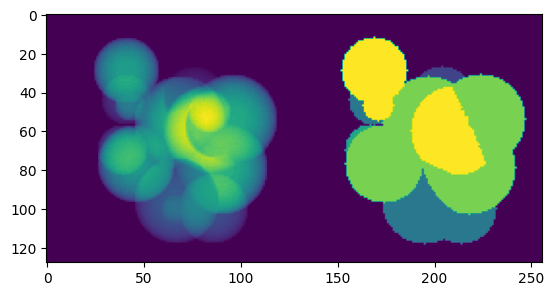

In [33]:
# Custom transform Lambdad
def sum_width(img):
    return img.sum(1)

def max_width(img):
    return img.max(1)

transform_custom3 = Compose([
    LoadImaged(fn_keys),
    EnsureChannelFirstd(fn_keys),
    Lambdad(("img"), sum_width),
    Lambdad(("seg"), max_width)
])

imgd = transform_custom3(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), np.squeeze(seg[0]))))

Dataset

In [35]:
images = [fn["img"] for fn in filenames]

transform_for_dataset = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst()
])

dataset = Dataset(images, transform_for_dataset)
first_tensor_in_dataset = dataset[0]

print(first_tensor_in_dataset.shape)

torch.Size([1, 128, 128, 128])


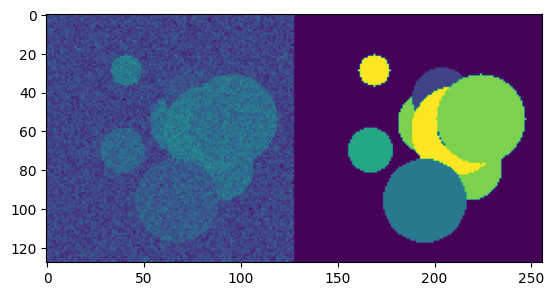

In [37]:
# Array_dataset -> two transform
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    RandSpatialCrop((128, 128, 128), random_size = False),
    RandGaussianNoise(.5, 1, 1)
])
seg_transform = Compose([
    LoadImage(image_only = True),
    EnsureChannelFirst(),
    RandSpatialCrop((128, 128, 128), random_size = False)
])

dataset = ArrayDataset(images, img_transform,
                       segs, seg_transform)
img, seg = dataset[0]

plt.imshow(np.hstack([
    img.numpy()[0,48], seg.numpy()[0, 48]
]))

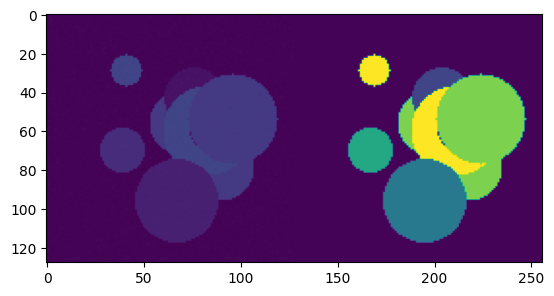

In [48]:
# dict -> 針對指定部分 transform
dict_transform = Compose([
    LoadImaged(fn_keys, image_only = False),
    EnsureChannelFirstd(fn_keys),
    RandGaussianNoised(("img"), (0.9)),
    RandSpatialCropd(fn_keys, (128, 128, 128), random_size = False)
])

dataset = Dataset(filenames, dict_transform)
item = dataset[0]
img, seg = item["img"], item["seg"]

plt.imshow(np.hstack([
    img.numpy()[0, 48], seg.numpy()[0, 48]
]))

Dataloader

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([5, 1, 128, 128, 128])


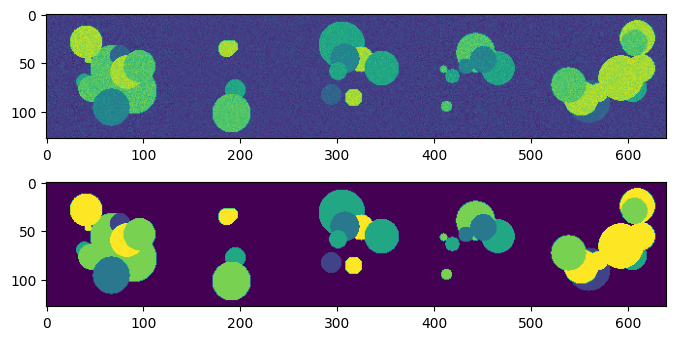

In [52]:
loader = DataLoader(dataset, batch_size = 5, num_workers = 2)
batch = first(loader)
print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize = (8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

Dataset caching

In [54]:
# deterministic transform will be saved and will only run first time

Layers

In [59]:
from monai.networks.layers import Conv, Act, split_args, Pool

In [65]:
print(Conv[Conv.CONV, 2](in_channels = 3,
                         out_channels = 64,
                         kernel_size = 3,
                         stride = 1,
                         padding = 1))

print(Conv[Conv.CONV, 3](in_channels = 3,
                         out_channels = 64,
                         kernel_size = 3,
                         stride = 1,
                         padding = 1))

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))


In [66]:
print(Conv[Conv.CONVTRANS, 2](in_channels = 64,
                              out_channels = 3,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1))

print(Conv[Conv.CONVTRANS, 3](in_channels = 64,
                              out_channels = 3,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1))

ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))


Activation

In [68]:
print(Act[Act.RELU])

<class 'torch.nn.modules.activation.ReLU'>


Network